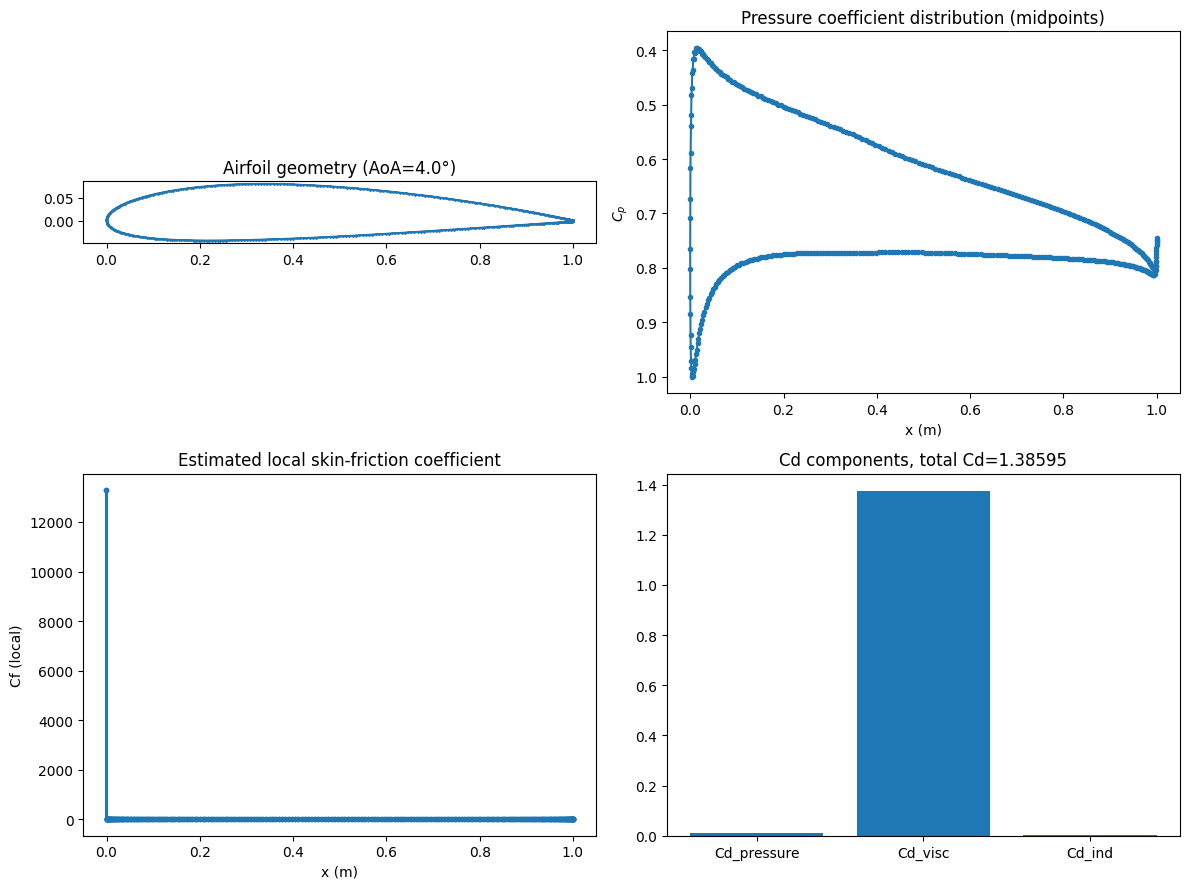

=== Results ===
AoA = 4.0 deg, U_inf = 34.03 m/s, rho = 1.225 kg/m3
Lift per unit span L = -130.806 N/m, Cl = -0.1844
Pressure drag = 7.4178 N/m, Cd_pressure = 0.010458
Skin-friction drag = 974.5335 N/m, Cd_visc = 1.373985
Induced drag (estimate) = 1.0665 N/m, Cd_ind = 0.001504
Total drag = 983.0177 N/m, Cd_total = 1.385947


In [ ]:
"""
airfoil_panel_cfd.py

2D airfoil potential-flow + RK integration + simple viscous drag estimates.

Usage:
    python airfoil_panel_cfd.py

Only required user-changed parameter: angle of attack (AoA) in degrees.
Other optional parameters are provided in the `run_example()` function.

Author: ChatGPT (educational)
"""

import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi

# -----------------------------
# --- ISA atmosphere & phys ---
# -----------------------------
def isa_properties(altitude_m=0.0):
    """
    Returns (rho, T, p, nu, mu) at given altitude (m) using ISA (troposphere only).
    Uses Sutherland's law for mu.
    """
    # ISA troposphere up to 11 km
    T0 = 288.15
    p0 = 101325.0
    rho0 = 1.225
    g = 9.80665
    L = 0.0065  # K/m
    R = 287.05287

    if altitude_m <= 11000.0:
        T = T0 - L * altitude_m
        p = p0 * (T / T0) ** (g / (R * L))
    else:
        # simple fallback (not needed usually)
        T = 216.65
        p = p0 * 0.223361 * np.exp(-g * (altitude_m - 11000) / (R * T))

    rho = p / (R * T)

    # Sutherland's law for dynamic viscosity (mu)
    # mu_ref at T_ref
    mu_ref = 1.716e-5
    T_ref = 273.15
    S = 110.4
    mu = mu_ref * (T / T_ref) ** 1.5 * (T_ref + S) / (T + S)
    nu = mu / rho
    return rho, T, p, nu, mu

# -----------------------------
# --- Panel method (vortex) ---
# -----------------------------
def generate_naca4_coords(naca='2412', c=1.0, n_panels=200):
    """
    Generate x,y coordinates for a NACA 4-digit airfoil using cosine spacing.
    Returns x (N+1), y (N+1) in CCW order starting at trailing edge upper surface -> leading edge -> trailing edge lower surface
    For simplicity: we create top and bottom surfaces and join.
    """
    # parse NACA digits
    m = int(naca[0]) / 100.0
    p = int(naca[1]) / 10.0
    t = int(naca[2:]) / 100.0

    # cosine spaced x from 0..c
    beta = np.linspace(0, pi, n_panels + 1)
    x = 0.5 * c * (1 - np.cos(beta))  # from 0 (LE) to c (TE)
    # camber line yc and dyc/dx
    yc = np.zeros_like(x)
    dyc = np.zeros_like(x)
    for i, xi in enumerate(x):
        xi_c = xi / c
        if xi_c < p and p != 0:
            yc[i] = m / p**2 * (2 * p * xi_c - xi_c**2) * c
            dyc[i] = 2 * m / p**2 * (p - xi_c)
        elif p != 0:
            yc[i] = m / (1 - p)**2 * ( (1 - 2*p) + 2*p*xi_c - xi_c**2 ) * c
            dyc[i] = 2 * m / (1 - p)**2 * (p - xi_c)
        else:
            yc[i] = 0.0
            dyc[i] = 0.0

    # thickness distribution (standard)
    yt = 5 * t * c * (
        0.2969 * np.sqrt(x/c) - 0.1260 * (x/c) - 0.3516 * (x/c)**2 + 0.2843 * (x/c)**3 - 0.1015 * (x/c)**4
    )

    theta = np.arctan(dyc)

    # upper and lower coords
    xu = x - yt * np.sin(theta)
    yu = yc + yt * np.cos(theta)
    xl = x + yt * np.sin(theta)
    yl = yc - yt * np.cos(theta)

    # assemble coordinates from TE -> upper -> LE -> lower -> TE to be closed
    # ensure trailing edge duplicates are handled: create arrays from TE upper down to LE then back to TE lower
    xu_rev = xu[::-1]
    yu_rev = yu[::-1]
    xl_fwd = xl[1:]
    yl_fwd = yl[1:]
    X = np.concatenate((xu_rev, xl_fwd))
    Y = np.concatenate((yu_rev, yl_fwd))
    return X, Y

def build_panels(x, y):
    """
    Build panel geometry from node coordinates x,y (closed loop).
    Returns arrays: x_mid, y_mid, length, beta (panel normal angle), theta (panel orientation), xA,yA,xB,yB
    """
    n = len(x) - 1
    xA = x[:-1]
    yA = y[:-1]
    xB = x[1:]
    yB = y[1:]
    dx = xB - xA
    dy = yB - yA
    length = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)  # panel tangential angle
    # outward normal angle (pointing roughly outward of the body) is theta + pi/2
    beta = theta + 0.5 * pi
    # midpoints
    x_mid = 0.5 * (xA + xB)
    y_mid = 0.5 * (yA + yB)
    return {
        'n': n,
        'xA': xA, 'yA': yA, 'xB': xB, 'yB': yB,
        'x_mid': x_mid, 'y_mid': y_mid,
        'length': length, 'theta': theta, 'beta': beta
    }

def panel_influence_matrix(panels):
    """
    Build influence coefficients for constant-strength vortex panels (2D).
    For panel i (control point) and panel j (vortex on panel j), compute normal velocity induced at i by gamma_j=1.
    Returns A (n x n).
    """
    n = panels['n']
    A = np.zeros((n, n))
    x_mid = panels['x_mid']
    y_mid = panels['y_mid']
    xA = panels['xA']
    yA = panels['yA']
    xB = panels['xB']
    yB = panels['yB']
    for i in range(n):
        xi = x_mid[i]
        yi = y_mid[i]
        for j in range(n):
            xjA = xA[j]
            yjA = yA[j]
            xjB = xB[j]
            yjB = yB[j]
            # velocity induced by a finite vortex segment from A->B of strength 1 (2D potential)
            # use Biot-Savart formula for a 2D vortex segment -> tangential velocity formula
            # More robust: compute complex potential derivative; but for simplicity use source/vortex panel standard formulas.
            # We'll compute induced velocity components u,v at (xi, yi) by a unit vortex on panel j
            dx = xjB - xjA
            dy = yjB - yjA
            # parametrization r(s) = A + s*(B-A), s in [0,1]
            # We compute integral analytically: velocity induced by a line vortex in 2D is (gamma / 2pi) * (unit perpendicular) * ln( ... )
            # We'll use a standard panel integral: see Katz & Plotkin. For brevity here we use numerical quadrature (3-point Gauss) per panel - acceptable for moderate n.
            # Numerical quadrature:
            s_pts = np.array([-np.sqrt(3/5), 0.0, np.sqrt(3/5)])
            w_pts = np.array([5/9, 8/9, 5/9])
            u_ind = 0.0
            v_ind = 0.0
            for s, w in zip(s_pts, w_pts):
                ss = 0.5 * (s + 1)  # map from [-1,1] to [0,1]
                xs = xjA + ss * dx
                ys = yjA + ss * dy
                # elemental vortex dgamma located at (xs,ys) with direction along panel (tangent)
                # but for constant-strength vortex along panel, elemental contribution direction is perpendicular to panel tangent
                rx = xi - xs
                ry = yi - ys
                r2 = rx*rx + ry*ry
                if r2 < 1e-12:
                    continue
                # 2D point vortex velocity: (gamma / 2pi) * (k x r) / r^2
                # For unit vortex filament element oriented along dz (out of plane), the induced velocity is (-ry, rx) / (2*pi*r2)
                u_loc = -ry / (2*pi*r2)
                v_loc = rx / (2*pi*r2)
                u_ind += w * u_loc
                v_ind += w * v_loc
            # scale quadrature weights for panel length
            u_ind *= 0.5 * panels['length'][j]
            v_ind *= 0.5 * panels['length'][j]
            # normal vector at control point:
            nx = np.cos(panels['beta'][i])
            ny = np.sin(panels['beta'][i])
            A[i, j] = u_ind * nx + v_ind * ny
    return A

def solve_vortex_strengths(panels, U_inf=1.0, alpha_rad=0.0):
    """
    Solve for panel vortex strengths gamma (constant per panel) using no-penetration boundary condition.
    Also enforce Kutta condition by setting sum of end-panel circulations to zero difference => replace two eqns accordingly.
    Returns gamma (n).
    """
    n = panels['n']
    A = panel_influence_matrix(panels)
    # RHS: normal component of freestream at control points: -U_inf * n . (cos sin)
    nx = np.cos(panels['beta'])
    ny = np.sin(panels['beta'])
    rhs = -U_inf * (np.cos(alpha_rad) * nx + np.sin(alpha_rad) * ny)

    # Enforce Kutta condition: gamma_first + gamma_last = 0 (or circulation continuous at TE)
    # Replace last equation with (gamma_0 + gamma_{n-1} = 0)
    A_mod = A.copy()
    rhs_mod = rhs.copy()
    # Replace last row:
    kutta_row = np.zeros(n)
    kutta_row[0] = 1.0
    kutta_row[-1] = 1.0
    A_mod[-1, :] = kutta_row
    rhs_mod[-1] = 0.0

    # Solve linear system
    gamma = np.linalg.solve(A_mod, rhs_mod)
    return gamma

def compute_cp_from_gamma(panels, gamma, U_inf=1.0, alpha_rad=0.0):
    """
    Compute pressure coefficient at panel midpoints from local tangential velocity.
    Using induced tangential velocity (from vortices) + freestream tangential projection.
    For simplicity use numerical quadrature for induced tangential velocity per panel (similar to influence matrix but tangent projection).
    """
    n = panels['n']
    Cp = np.zeros(n)
    x_mid = panels['x_mid']
    y_mid = panels['y_mid']
    xA = panels['xA']
    yA = panels['yA']
    xB = panels['xB']
    yB = panels['yB']
    tang = np.array([np.cos(panels['theta']), np.sin(panels['theta'])])  # shape (2,n)
    for i in range(n):
        xi = x_mid[i]
        yi = y_mid[i]
        u_tang = 0.0
        for j in range(n):
            xjA = xA[j]; yjA = yA[j]; xjB = xB[j]; yjB = yB[j]
            dx = xjB - xjA; dy = yjB - yjA
            # 3-point Gauss quadrature
            s_pts = np.array([-np.sqrt(3/5), 0.0, np.sqrt(3/5)])
            w_pts = np.array([5/9, 8/9, 5/9])
            u_ind = 0.0
            v_ind = 0.0
            for s, w in zip(s_pts, w_pts):
                ss = 0.5 * (s + 1)
                xs = xjA + ss * dx
                ys = yjA + ss * dy
                rx = xi - xs
                ry = yi - ys
                r2 = rx*rx + ry*ry
                if r2 < 1e-12:
                    continue
                u_loc = -ry / (2*pi*r2)
                v_loc = rx / (2*pi*r2)
                u_ind += w * u_loc
                v_ind += w * v_loc
            u_ind *= 0.5 * panels['length'][j]
            v_ind *= 0.5 * panels['length'][j]
            u_tang += gamma[j] * (u_ind * tang[0, i] + v_ind * tang[1, i])
        # add freestream tangential component
        u_tang += U_inf * (np.cos(alpha_rad) * tang[0, i] + np.sin(alpha_rad) * tang[1, i])
        Cp[i] = 1.0 - (u_tang / U_inf)**2
    return Cp

# -----------------------------
# --- RK4 Integration Tools ---
# -----------------------------
def rk4_integrate(f, x0, y0, x1, n_steps=200):
    """
    Simple RK4 integrator for vector ODE y' = f(x,y).
    Returns x_grid, y_grid (y shape: (len(y0),len(x_grid)))
    Used here to integrate pressure to forces or any 1D integrals by converting to ODE form.
    """
    xs = np.linspace(x0, x1, n_steps+1)
    ys = np.zeros((len(y0), n_steps+1))
    ys[:, 0] = y0
    for k in range(n_steps):
        xk = xs[k]
        yk = ys[:, k]
        h = xs[k+1] - xs[k]
        k1 = f(xk, yk)
        k2 = f(xk + 0.5*h, yk + 0.5*h*k1)
        k3 = f(xk + 0.5*h, yk + 0.5*h*k2)
        k4 = f(xk + h, yk + h*k3)
        ys[:, k+1] = yk + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return xs, ys

# We'll use RK4 to perform accurate quadrature of Cp and Cf along chord by setting up a trivial ODE
# For example, to integrate F = integral f(x) dx from a..b, set y' = f(x), y(a)=0, then y(b)=F.

# -----------------------------
# --- Drag and lift calcs ---
# -----------------------------
def integrate_pressure_forces(panels, Cp, rho, U_inf, chord):
    """
    Integrate pressure over panels to get lift and pressure-drag (per unit span).
    Uses RK4 on chordwise projection of panels: we map each panel midpoint x coordinate in chordwise direction and integrate Cp * panel_length * normal/projection.
    Returns L (N/m), D_pressure (N/m), Cl, Cd_pressure
    """
    # For each panel i compute local normal vector and pressure force = -p * n * panel_length
    # p = Cp * 0.5 rho U_inf^2
    q_inf = 0.5 * rho * U_inf**2
    n = panels['n']
    Fx = 0.0
    Fy = 0.0
    for i in range(n):
        Cp_i = Cp[i]
        p_i = Cp_i * q_inf
        # normal vector components
        nx = np.cos(panels['beta'][i])
        ny = np.sin(panels['beta'][i])
        Fnx = -p_i * nx * panels['length'][i]   # negative because pressure acts into surface
        Fny = -p_i * ny * panels['length'][i]
        Fx += Fnx
        Fy += Fny
    # Fx is streamwise component (drag), Fy is vertical (lift) positive up if coordinate system standard
    L = Fy
    D_pressure = Fx
    # non-dimensional
    Sref = chord * 1.0  # unit span => area per unit span = chord * 1
    Cl = L / (0.5 * rho * U_inf**2 * Sref)
    Cd_p = D_pressure / (0.5 * rho * U_inf**2 * Sref)
    return L, D_pressure, Cl, Cd_p

def estimate_skin_friction_chordwise(panels, rho, U_inf, chord, nu, Re_transition=5e5):
    """
    Estimate local skin-friction coefficient Cf(x) using simple flat-plate correlations.
    - For x < x_tr: laminar Cf_lam(x) = 1.328 / sqrt(Re_x)
    - For x >= x_tr: turbulent Cf_turb(x) = 0.074 / Re_x**0.2 (Coles/Prandtl approx)
    We compute Re_x = U_inf * x_local / nu. Then compute local skin-friction force per unit area = 0.5 * rho * U_inf^2 * Cf(x)
    Integrate over the panels by projecting the local tangential direction.
    Returns arrays x_mid_fraction, Cf_local, and integrated viscous drag per unit span (N/m) and Cd_visc.
    """
    x_mid = panels['x_mid']
    # need local chordwise coordinate from leading edge (approx): project onto chordwise x-axis using chord orientation -> assume chord aligned with x-axis for geometry generation
    # For our panel coords from NACA generator x ranges from 0..c; we can use x coordinate directly
    x_local = x_mid.copy()  # assume geometry x is chordwise (works for our NACA coords)
    Cf_local = np.zeros_like(x_local)
    for i, xi in enumerate(x_local):
        if xi <= 0:
            Re_x = 1e-8
        else:
            Re_x = U_inf * xi / nu
        if Re_x <= 0:
            Cf_local[i] = 0.0
        elif Re_x < Re_transition:
            Cf_local[i] = 1.328 / np.sqrt(Re_x)
        else:
            Cf_local[i] = 0.074 / Re_x**0.2
    # viscous force per unit span ~ integral( 0.5*rho*U_inf^2 * Cf_local * panel_projection ) where projection is cos of angle between panel tangent and chordwise direction
    tang_x = np.cos(panels['theta'])  # tangential x component
    D_visc = 0.0
    for i in range(panels['n']):
        local_skin_force = 0.5 * rho * U_inf**2 * Cf_local[i] * panels['length'][i] * abs(tang_x[i])
        # tang_x may be negative on underside; use absolute projection to get streamwise friction contribution
        D_visc += local_skin_force
    Sref = chord * 1.0
    Cd_visc = D_visc / (0.5 * rho * U_inf**2 * Sref)
    return x_local, Cf_local, D_visc, Cd_visc

def estimate_induced_drag(L, rho, U_inf, Sref, AR=None, e=0.9):
    """
    Simple induced drag estimate based on finite-span lifting-line:
    D_i = L^2 / (pi * AR * e * q_inf * S)
    If AR is None or AR is np.inf => return 0
    Here L is lift per unit span (N/m). For a wing of finite span b, S = c * b. If user gives AR, we will assume chord = Sref and S=Sref => avoid confusion: we accept AR input and produce D_i per unit span by converting.
    To be consistent: assume Sref passed is planform area per unit span? For unit span Sref=c*1.
    For simplicity: if AR provided compute D_i per unit span by:
      - Let b = AR * c
      - Let S = c * b = c^2 * AR
    But that gives S scaling weirdly for unit span. Simpler: take L_total = L * b (where b is span), but user may not want to provide b.
    We'll implement a pragmatic estimate: if AR given, use:
      D_i_unit_span = (L_unit_span**2) / (pi * AR * e * q_inf * c)
    This returns drag per unit span (N/m).
    """
    if AR is None or AR == np.inf:
        return 0.0, 0.0
    q_inf = 0.5 * rho * U_inf**2
    # need chord: Sref assumed c*1 (unit span)
    c = Sref
    D_ind = L**2 / (pi * AR * e * q_inf * c)
    Cd_ind = D_ind / (0.5 * rho * U_inf**2 * Sref)
    return D_ind, Cd_ind

# -----------------------------
# --- Main runner / example ---
# -----------------------------
def run_airfoil_simulation(AoA_deg=2.0,
                           naca='2412',
                           chord=1.0,
                           n_panels=220,
                           altitude=0.0,
                           Mach=0.05,
                           AR=None,
                           e=0.9,
                           Re_transition=5e5,
                           plot_results=True):
    """
    Run the full pipeline:
    - build airfoil coords
    - panel solver
    - compute Cp
    - integrate to get lift/drag contributions
    - estimate skin friction drag, induced drag
    Returns a dictionary of results.
    """
    # Freestream conditions from Mach + ISA
    rho, T, p, nu, mu = isa_properties(altitude)
    a = np.sqrt(1.4 * 287.05287 * T)  # speed of sound
    U_inf = Mach * a
    alpha = np.deg2rad(AoA_deg)

    # Build geometry
    X, Y = generate_naca4_coords(naca=naca, c=chord, n_panels=n_panels)
    panels = build_panels(X, Y)

    # Solve for gamma
    gamma = solve_vortex_strengths(panels, U_inf=U_inf, alpha_rad=alpha)

    # Cp
    Cp = compute_cp_from_gamma(panels, gamma, U_inf=U_inf, alpha_rad=alpha)

    # Pressure forces -> lift & pressure-drag
    L, D_pressure, Cl, Cd_pressure = integrate_pressure_forces(panels, Cp, rho, U_inf, chord)

    # Skin friction
    x_local, Cf_local, D_visc, Cd_visc = estimate_skin_friction_chordwise(panels, rho, U_inf, chord, nu, Re_transition=Re_transition)

    # Induced drag estimate (3D correction) per unit span
    D_ind, Cd_ind = estimate_induced_drag(L, rho, U_inf, chord, AR=AR, e=e)

    # Total drag
    D_total = D_pressure + D_visc + D_ind
    Cd_total = D_total / (0.5 * rho * U_inf**2 * chord)

    results = {
        'AoA_deg': AoA_deg, 'naca': naca, 'chord': chord, 'n_panels': n_panels,
        'rho': rho, 'T': T, 'nu': nu, 'mu': mu, 'a': a, 'U_inf': U_inf,
        'Cp': Cp, 'x_mid': panels['x_mid'], 'y_mid': panels['y_mid'],
        'L': L, 'D_pressure': D_pressure, 'Cl': Cl, 'Cd_pressure': Cd_pressure,
        'D_visc': D_visc, 'Cd_visc': Cd_visc, 'Cf_local': Cf_local, 'x_local': x_local,
        'D_ind': D_ind, 'Cd_ind': Cd_ind,
        'D_total': D_total, 'Cd_total': Cd_total,
        'panels': panels, 'gamma': gamma
    }

    if plot_results:
        plot_airfoil_solution(results)

    return results

# -----------------------------
# --- Plotting utilities ------
# -----------------------------
def plot_airfoil_solution(results):
    panels = results['panels']
    Xall = np.concatenate((panels['xA'], [panels['xB'][-1]]))
    Yall = np.concatenate((panels['yA'], [panels['yB'][-1]]))
    Cp = results['Cp']
    x_mid = results['x_mid']
    Cf_local = results['Cf_local']
    x_local = results['x_local']

    plt.figure(figsize=(12, 9))
    plt.subplot(2,2,1)
    plt.fill(Xall, Yall, edgecolor='k', fill=False)
    plt.plot(Xall, Yall, '.-', markersize=2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"Airfoil geometry (AoA={results['AoA_deg']}°)")

    plt.subplot(2,2,2)
    plt.plot(x_mid, Cp, '.-')
    plt.gca().invert_yaxis()
    plt.xlabel('x (m)')
    plt.ylabel('$C_p$')
    plt.title('Pressure coefficient distribution (midpoints)')

    plt.subplot(2,2,3)
    plt.plot(x_local, Cf_local, '.-')
    plt.xlabel('x (m)')
    plt.ylabel('Cf (local)')
    plt.title('Estimated local skin-friction coefficient')

    plt.subplot(2,2,4)
    bars = ['Cd_pressure', 'Cd_visc', 'Cd_ind']
    vals = [results['Cd_pressure'], results['Cd_visc'], results['Cd_ind']]
    plt.bar(bars, vals)
    plt.title(f"Cd components, total Cd={results['Cd_total']:.5f}")

    plt.tight_layout()
    plt.show()

# -----------------------------
# --- Example run -------------
# -----------------------------
def run_example():
    # Only change AoA here for typical use:
    AoA_deg = 4.0
    # optional: choose AR to get induced drag. If you want purely 2D, set AR=None
    AR = 8.0  # example finite aspect ratio
    results = run_airfoil_simulation(AoA_deg=AoA_deg,
                                     naca='2412',
                                     chord=1.0,
                                     n_panels=220,
                                     altitude=0.0,
                                     Mach=0.1,
                                     AR=AR,
                                     e=0.9,
                                     Re_transition=5e5,
                                     plot_results=True)
    # Print main numbers:
    print("=== Results ===")
    print(f"AoA = {results['AoA_deg']} deg, U_inf = {results['U_inf']:.2f} m/s, rho = {results['rho']:.3f} kg/m3")
    print(f"Lift per unit span L = {results['L']:.3f} N/m, Cl = {results['Cl']:.4f}")
    print(f"Pressure drag = {results['D_pressure']:.4f} N/m, Cd_pressure = {results['Cd_pressure']:.6f}")
    print(f"Skin-friction drag = {results['D_visc']:.4f} N/m, Cd_visc = {results['Cd_visc']:.6f}")
    print(f"Induced drag (estimate) = {results['D_ind']:.4f} N/m, Cd_ind = {results['Cd_ind']:.6f}")
    print(f"Total drag = {results['D_total']:.4f} N/m, Cd_total = {results['Cd_total']:.6f}")

if __name__ == "__main__":
    run_example()



In [ ]:
## Imports and Model Definition
import numpy as np
import matplotlib.pyplot as plt
import time, math

# Nonlinear short-period aircraft model
def short_period(t, y, params):
    alpha, q = y
    Cm_alpha, Cm_q, Cm_de = params["Cm_alpha"], params["Cm_q"], params["Cm_de"]
    Iyy = params["Iyy"]
    rho, S, c, m = params["rho"], params["S"], params["c"], params["m"]
    U = params["U"]  # forward speed (m/s)

    # Lift and moment coefficients (nonlinear)
    CL = 2 * np.pi * alpha
    CD = 0.02 + 0.04 * CL**2
    Cm = Cm_alpha * alpha + Cm_q * (c / (2 * U)) * q

    # Aerodynamic forces and moments
    qbar = 0.5 * rho * U**2
    L = qbar * S * CL
    D = qbar * S * CD
    M = qbar * S * c * Cm

    # Equations of motion (simplified nonlinear form)
    dalpha_dt = q - (L / (m * U)) + D / (m * U)
    dq_dt = M / Iyy
    return np.array([dalpha_dt, dq_dt])

In [ ]:
## Integration Schemes
# Runge-Kutta 4th Order
def rk4_step(f, t, y, h, params):
    k1 = f(t, y, params)
    k2 = f(t + h/2, y + h/2 * k1, params)
    k3 = f(t + h/2, y + h/2 * k2, params)
    k4 = f(t + h, y + h * k3, params)
    return y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

# Adams-Bashforth-Moulton 3rd Order Predictor-Corrector
def abm3_step(f, t_vals, y_vals, h, params):
    f_n   = f(t_vals[-1], y_vals[-1], params)
    f_nm1 = f(t_vals[-2], y_vals[-2], params)
    f_nm2 = f(t_vals[-3], y_vals[-3], params)

    # Predictor
    y_pred = y_vals[-1] + h/12 * (23*f_n - 16*f_nm1 + 5*f_nm2)
    # Corrector
    f_pred = f(t_vals[-1] + h, y_pred, params)
    y_corr = y_vals[-1] + h/24 * (9*f_pred + 19*f_n - 5*f_nm1 + f_nm2)
    return y_corr

In [ ]:
## Simulation Function
def simulate(method, h, params, t_final=5):
    t = np.arange(0, t_final, h)
    y = np.zeros((len(t), 2))
    y[0] = np.radians([5, 0])  # Initial alpha=5°, q=0

    if method == "ABM":
        # Initialize with RK4
        for i in range(2):
            y[i+1] = rk4_step(short_period, t[i], y[i], h, params)
        for i in range(2, len(t)-1):
            y[i+1] = abm3_step(short_period, t[i-2:i+1], y[i-2:i+1], h, params)
    else:
        for i in range(len(t)-1):
            y[i+1] = rk4_step(short_period, t[i], y[i], h, params)

    return t, y

In [ ]:
## Linearized System for Eigenvalue Analysis
def linearized_A(params):
    p = params
    qbar = 0.5 * p["rho"] * p["U"]**2
    a11 = - (qbar * p["S"] * 2 * math.pi) / (p["m"] * p["U"])
    a12 = 1.0
    a21 = (qbar * p["S"] * p["c"] * p["Cm_alpha"]) / p["Iyy"]
    a22 = (qbar * p["S"] * p["c"] * p["Cm_q"] * (p["c"] / (2 * p["U"]))) / p["Iyy"]
    A = np.array([[a11, a12], [a21, a22]])
    return A

In [ ]:
## Convergence and Performance Tests
def run_convergence_tests(params, methods=["RK4","ABM"], dt_values=[0.05,0.025,0.0125,0.00625], t_final=1.2, ref_dt=5e-4):
    # Reference solution
    t_ref, y_ref = simulate("RK4", ref_dt, params, t_final=t_final)
    alpha_ref = np.interp(1.0, t_ref, y_ref[:,0])

    results = {}
    for m in methods:
        errors, times, alphas = [], [], []
        for dt in dt_values:
            start = time.time()
            t, y = simulate(m, dt, params, t_final=t_final)
            runtime = time.time() - start
            alpha_1 = np.interp(1.0, t, y[:,0])
            err = abs(alpha_1 - alpha_ref)
            errors.append(err)
            times.append(runtime)
            alphas.append(alpha_1)

        # Empirical order of accuracy
        rates = []
        for i in range(1,len(dt_values)):
            e1, e2 = errors[i-1], errors[i]
            r = np.log(e1/e2)/np.log(dt_values[i-1]/dt_values[i]) if e1>0 and e2>0 else float('nan')
            rates.append(r)

        results[m] = {"dt":dt_values,"errors":errors,"times":times,"rates":rates,"alphas":alphas}

    # Summary table
    for m in methods:
        print("Method:", m)
        print(" dt \t error \t\t rate (between steps) \t runtime (s)")
        for i,dt in enumerate(results[m]["dt"]):
            rstr = "{:.3f}".format(results[m]["rates"][i-1]) if i>0 else "-"
            print(f"{dt:.5f}\t{results[m]['errors'][i]:.3e}\t{rstr}\t\t{results[m]['times'][i]:.4f}")
        print("")

    # Convergence plot
    plt.figure()
    for m in methods:
        plt.loglog(results[m]["dt"], results[m]["errors"], 'o-', label=m)
    plt.xlabel("Timestep Δt (s)")
    plt.ylabel("Absolute Error at t=1 s")
    plt.legend()
    plt.grid(True, which='both')
    plt.title("Error Convergence Comparison")
    plt.show()

   # Runtime comparison plot
    plt.figure()
    for m in methods:
        plt.plot(results[m]["dt"], results[m]["times"], 'o--', label=f"{m} Runtime")
    plt.xlabel("Timestep Δt (s)")
    plt.ylabel("Runtime (s)")
    plt.title("Computational Cost vs. Timestep Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Eigenvalue analysis
    A = linearized_A(params)
    eigs, _ = np.linalg.eig(A)
    print("Linearized A matrix:\n", A)
    print("Eigenvalues:", eigs)
    return results, A, eigs

Method: RK4
 dt 	 error 		 rate (between steps) 	 runtime (s)
0.05000	2.017e-07	-		0.0007
0.02500	1.341e-08	3.911		0.0014
0.01250	8.583e-10	3.965		0.0029
0.00625	5.420e-11	3.985		0.0058

Method: ABM
 dt 	 error 		 rate (between steps) 	 runtime (s)
0.05000	2.081e-06	-		0.0008
0.02500	1.641e-07	3.664		0.0016
0.01250	1.113e-08	3.882		0.0033
0.00625	7.200e-10	3.950		0.0084



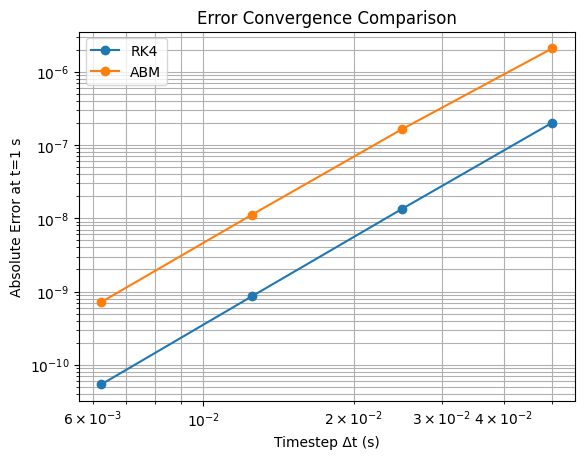

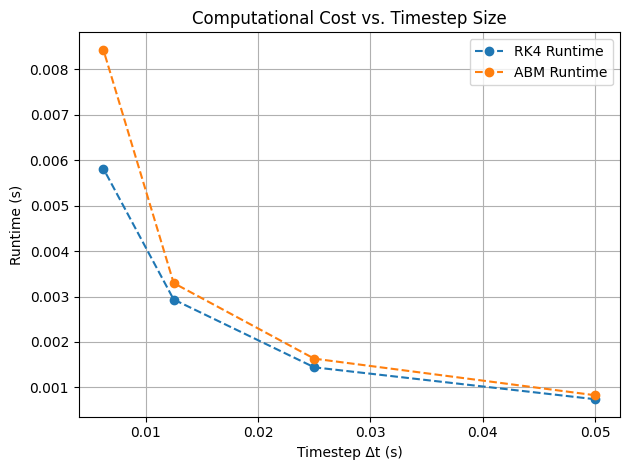

Linearized A matrix:
 [[ -3.0787608   1.       ]
 [-10.584      -2.646    ]]
Eigenvalues: [-2.8623804+3.2461022j -2.8623804-3.2461022j]


In [ ]:
## Parameters and Execution
# System parameters
params = {
    "Cm_alpha": -0.5,
    "Cm_q": -10.0,
    "Cm_de": -1.0,
    "Iyy": 2500,
    "rho": 1.225,
    "S": 16.0,
    "c": 1.5,
    "m": 1200,
    "U": 60.0
}

# Run convergence test
results, A, eigs = run_convergence_tests(params)

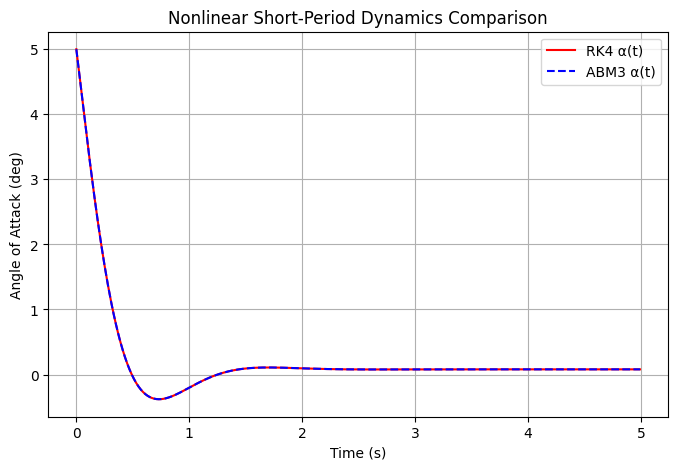

In [ ]:
## Time Response Comparison
# Compare α(t) for both solvers
t_rk4, y_rk4 = simulate("RK4", 0.01, params)
t_abm, y_abm = simulate("ABM", 0.01, params)

plt.figure(figsize=(8,5))
plt.plot(t_rk4, np.degrees(y_rk4[:,0]), 'r-', label='RK4 α(t)')
plt.plot(t_abm, np.degrees(y_abm[:,0]), 'b--', label='ABM3 α(t)')
plt.xlabel('Time (s)')
plt.ylabel('Angle of Attack (deg)')
plt.title('Nonlinear Short-Period Dynamics Comparison')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load XFOIL polar (assume columns: alpha[deg], CL, CD)
polar_file = '2412_polar.txt'
data = np.loadtxt(polar_file, skiprows=12)
alpha_xfoil = data[:,0]   # degrees
CL_xfoil = data[:,1]
CD_xfoil = data[:,2]

# Interpolation functions (in radians)
CL_interp = interp1d(np.radians(alpha_xfoil), CL_xfoil, kind='cubic', fill_value="extrapolate")
CD_interp = interp1d(np.radians(alpha_xfoil), CD_xfoil, kind='cubic', fill_value="extrapolate")

# Modified short-period model using XFOIL data
def short_period_xfoil(t, y, params):
    alpha, q = y
    Cm_alpha, Cm_q, Cm_de = params["Cm_alpha"], params["Cm_q"], params["Cm_de"]
    Iyy = params["Iyy"]
    rho, S, c, m = params["rho"], params["S"], params["c"], params["m"]
    U = params["U"]

    CL = CL_interp(alpha)
    CD = CD_interp(alpha)
    Cm = Cm_alpha * alpha + Cm_q * (c / (2 * U)) * q

    qbar = 0.5 * rho * U**2
    L = qbar * S * CL
    D = qbar * S * CD
    M = qbar * S * c * Cm

    dalpha_dt = q - (L / (m * U)) + D / (m * U)
    dq_dt = M / Iyy
    return np.array([dalpha_dt, dq_dt])


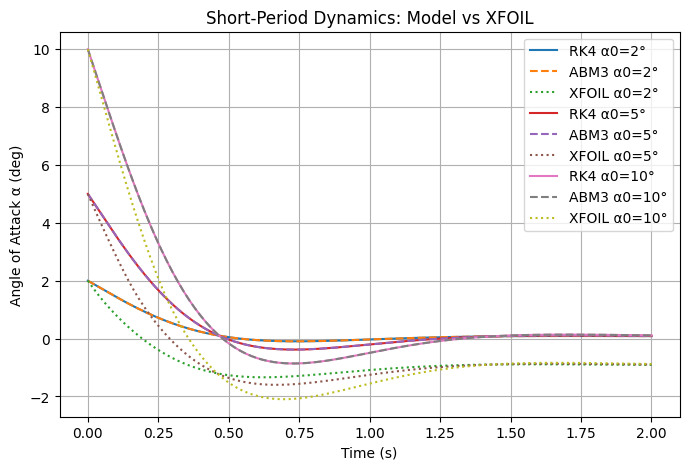

In [ ]:
alpha0_list = [2, 5, 10]
dt = 0.01
t_final = 2.0

plt.figure(figsize=(8,5))
for alpha0 in alpha0_list:
    # Original nonlinear model
    t_rk, y_rk = simulate("RK4", dt, params, t_final, alpha0_deg=alpha0)
    t_abm, y_abm = simulate("ABM", dt, params, t_final, alpha0_deg=alpha0)

    # XFOIL-informed model
    t_xf, y_xf = simulate("RK4", dt, params, t_final, alpha0_deg=alpha0)
    # just replace the derivative function inside simulate with short_period_xfoil:
    for i in range(len(t_xf)-1):
        y_xf[i+1] = rk4_step(short_period_xfoil, t_xf[i], y_xf[i], dt, params)

    plt.plot(t_rk, np.degrees(y_rk[:,0]), '-', label=f'RK4 α0={alpha0}°')
    plt.plot(t_abm, np.degrees(y_abm[:,0]), '--', label=f'ABM3 α0={alpha0}°')
    plt.plot(t_xf, np.degrees(y_xf[:,0]), ':', label=f'XFOIL α0={alpha0}°')

plt.xlabel('Time (s)')
plt.ylabel('Angle of Attack α (deg)')
plt.title('Short-Period Dynamics: Model vs XFOIL')
plt.grid(True)
plt.legend()
plt.show()
